In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# 目标检测任务的评价指标

1. 处理模型输出
    1. 对模型输出，筛选出得分（confidence或f1_score）高于阈值的预测
    2. 对筛选出的预测做 NMS，得到要保留的预测

2. 预测与目标的匹配（我们称“击中”）：
    - 经步骤1得到的 prediction (pred)，检查每个 pred 是否击中以及击中哪一个 ground truth object (gto)
    - 检查某个 pred 是否击中以及击中哪个 gto 的方法：
        1. 找出与该 pred 类别相同的 gto (记为gto_c)
        2. 计算该 pred 与各 gto_c 的 IoU
        3. 若各 IoU 都不大于阈值 (hit_IoU_threshold)，则认为该 pred 没有击中任何 gto
        4. 若存在大于阈值的 IoU，找出 IoU 最大的那个 gto_c，则认为该 pred 击中了该 gto_c
    - 跟据此方法：一个 pred 可以不击中任何或者仅击中一个 gto；一个 gto 可以不被任何或者被一个或者被多个 pred 击中

3. 统计tp，fp，fn
    1. 按照类别分别统计
    2. 统计tp
        - tp = number of gto's those are hit by any pred
    3. 统计fp
        - fp = prediction - tp
    4. 统计fn
        - fn = truth - tp

4. precision-recall curve
    - 按类别统计precision和recall
    - 对每个类别，计算 filt_threshold 从小到大取不同值时的 tp,prediction,truch
    - 在每个类别，每个 filt_threshold 处，计算 precision 和 recall
        - precision = tp/prediction
        - recall = tp/truth
    - precition recall curve
        - 每个类别单独一条曲线
        - 对一个类别，以 recall 为横轴，precision 为纵轴，绘制曲线
    - 注意：
        - 曲线的平滑程度取决于 filt_threshold 的值的密度，它越密则曲线越平滑
        - 不同的情况对 filt_threshold 的密度的要求是不同的
            - 有的模型对 filt_threshold 不敏感，例如模型训练的很好，它对目标预测的confdience都非常高（接近1），对非目标预测的confidence都非常低（接近0），那么 filt_threshold 要设置的很密才能看到 prc 的连续变化
            - 有的模型对 filt_threshold 比较敏感，例如模型训练的一般，它对目标预测和对非目标预测的confidence的区分不那么明显，那么 filt_threshold 并不需要设置的很密就能看到 prc 的连续变化

4. 计算AP
    - 对每个类别（每条prc曲线）计算一个AP
    - 计算AP的方法：
        1. 选取11个recall值：\[0, 0.1, 0.2, ..., 1.0\]
        2. 对每个recall值，找出该值右侧曲线中的最大precision值
        3. 对找出的11个最大precision值求平均，为该条prc曲线的AP

5. 计算 mAP
    - 所有类别的AP的平均值

# import

In [2]:
import torch

In [3]:
from ..exp import databunch
from ..exp import anchors_loss_metrics
from ..exp import resnet_ssd
from ..exp import interpretation

In [4]:
from fastai.basic_train import Learner

In [5]:
import numpy as np

In [6]:
from torch import tensor

In [7]:
from fastprogress.fastprogress import master_bar,progress_bar

In [8]:
import collections

In [9]:
from matplotlib import pyplot as plt

In [10]:
from IPython.core import debugger as idb

# functions

## get_TpFpFn

In [11]:
# export
def count(L):
    '''
    统计tensor中各元素出现的次数,返回一个字典，键为各元素，值为各元素出现的次数
    '''
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x.item()] += 1
    return result

In [12]:
# export
def get_TpFpFn(dl,model,n_clas,hit_thres,filt_thress,device,gaf):
    '''
    参数：
    --dl：一个dataloader，这是计算tpfpfn的数据集
    --model：模型
    --n_clas：类别数
    --hit_thres：预测框与目标框的IoU高于该值则认为该预测框击中（或称匹配）上了该目标
    --filt_thress：一列filt_threshold，得分高于该阈值的预测框才会参加 nms
    --device：torch.device对象
    --gaf：一个GridAnchor_Funcs对象（见exp/anchors_loss_metrics.py）
    '''
    pd = torch.zeros((len(filt_thress),n_clas)) # prediction
    gt = torch.zeros((len(filt_thress),n_clas)) # ground truth
    tp = torch.zeros((len(filt_thress),n_clas)) # true positive
    
    # 遍历dl中的每个databunch
    mb = master_bar(dl)
    mb.main_bar.comment = 'batchs'
    for x,y in mb:
        # 模型做预测，并处理其输出
        netOut = model(x.to(device))
        
        # 由低到高遍历不同的filt_thres
        cb = progress_bar(filt_thress, parent=mb) # child bar
        mb.child.comment = 'filt_thress'
        for i,filt_thres in enumerate(cb): 
            # pb: prediction batch
            pb_boxs, _, pb_cats, _, _ = interpretation.netouts2preds(batchOut=netOut,
                                                                        gaf=gaf,
                                                                        composeConfPrb=True,
                                                                        filt_thres=filt_thres,
                                                                        ov_thres=0.2,
                                                                        despiteCat=True)
            # 遍历databunch中每一条数据
            for idx in range(0,x.shape[0]):
                p_boxs = pb_boxs[idx] # p: prediction
                p_cats = pb_cats[idx]
                
                if len(p_cats)>0:
                    count_pred = count(p_cats)
                    pred_cats = [k for k in count_pred.keys()]
                    pred_cnts = tensor([v for v in count_pred.values()])
                    pd[i][pred_cats] += pred_cnts
                
                gt_boxs,gt_clas = y[0][idx],y[1][idx] # gt: ground truch
                keep = anchors_loss_metrics.get_y(gt_boxs)
                if len(keep)>0:
                    gt_boxs = gt_boxs[keep]
                    gt_clas = gt_clas[keep]
                    gt_boxs = (gt_boxs + 1) / 2
                    gt_clas = gt_clas - 1

                    count_gt = count(gt_clas)
                    gt_cats = [k for k in count_gt.keys()]
                    gt_cnts = tensor([v for v in count_gt.values()])
                    gt[i][gt_cats] += gt_cnts
                
                if len(keep)==0 or len(p_cats)==0:
                    continue
                
                
                #---------------------------------------------------------------------------------
                #-------- 击中匹配 ---------------------------------------------------------------
                #---------------------------------------------------------------------------------
                # 1. 计算IoU匹配矩阵
                ious = anchors_loss_metrics.iou(p_boxs[:,None,:],gt_boxs[None,:,:])
                # 2. 仅保留IoU高于阈值的匹配
                ious = torch.where(ious > hit_thres, ious, tensor(0.,device=device))

                # 3. 仅保留类别一致的匹配
                mask_sameClas = (gt_clas[None,:]==p_cats[:,None])
                ious_sameClas = torch.where(mask_sameClas,ious,tensor(0.,device=device))

                # 4. 每个pred仅保留IoU最大的一个匹配，作为hit
                hit_yes = ious_sameClas.sum(axis=1)>0
                hit_who = torch.argmax(ious_sameClas,axis=1)
                hit_who = hit_who[hit_yes]
                
                if len(hit_who)==0:
                    continue
 
                # 5. 统计被击中的gt，即使被多次击中也只统计一次
                who_isHit = tensor(list(set(hit_who)))
                who_isHit = gt_clas[who_isHit]
                
                # 6. 统计
                count_tp = count(who_isHit)
                tp_cats = [k for k in count_tp.keys()]
                tp_cnts = tensor([v for v in count_tp.values()])
                tp[i][tp_cats] += tp_cnts
                
    fp = pd - tp
    fn = gt - tp
                
    return tp, fp, fn, pd, gt

## get_recall_precision

In [13]:
def get_recall_precision(tp, pd, gt):
    '''
    参数：
    --tp：true positive
    --pd：prediction
    --gt：ground truth
    '''
    eps = np.where(pd==0,1,0)
    precision = (tp+eps)/(pd+eps)

    eps = np.where(gt==0,1,0)
    recall = (tp+eps)/(gt+eps)
    
    return precision, recall

## draw_rpc

In [94]:
def find_bestIdx(recall,precision):
    # 图上各点到原点的距离的平方
    r2 =  pow(precision,2)+pow(recall,2)
    max_ids = r2.argmax(0)  
    return max_ids 

def draw_rpc(recall,precision,thress):
    '''
    按各类别绘制 recall-precision 曲线，标出每条曲线上的最优点，打印最优点对应的阈值及recall和precision。
    并返回这些最优点对应的阈值。
    '''
    max_ids = find_bestIdx(recall,precision)
    
    n_clas = recall.shape[1]
    rows = int(n_clas/4)
    _, axs = plt.subplots(rows,4,figsize=(20,5*rows))
    axs = axs.flatten()
    
    for i in range(n_clas):
        axs[i].plot(recall[:,i], precision[:,i])
        
        maxid = max_ids[i]
        axs[i].scatter(recall[maxid,i],precision[maxid,i],color='red')
        axs[i].set_title('best@{:.3f},prcn={:.2f},rcal={:.2f}'.format(thress[maxid],precision[maxid,i],recall[maxid,i]))
        
    return thress[max_ids]

## AP：Average Precision

In [89]:
def get_AP(recall,precision):
    '''
    按各类别计算 average precision
    '''
    n_clas = recall.shape[1]
    ap = torch.zeros(n_clas)
    for i in range(0,n_clas):
        recall_clas_i = recall[:,i]
        precision_clas_i = precision[:,i]
        
        prec_at_rec = []
        for recall_level in torch.linspace(0, 1, 11):
            try:
                right_idx = torch.where(recall_clas_i >= recall_level)[0]
                right_max = max(precision_clas_i[right_idx])
            except ValueError:
                right_max = 0.0
            prec_at_rec.append(right_max)
        ap[i] = tensor(prec_at_rec).mean()
        
    return ap

# test

## 准备learner

In [16]:
device = torch.device('cuda')

In [17]:
data = databunch.get_databunch(data_root='./data/tiny_ds_20200331',bs=64,device=device,cache=False) 

In [18]:
classes = data.train_ds.y.classes
classes = classes[1:]
num_clas = len(classes)

In [19]:
gvs,_,_,avs,_,_ = anchors_loss_metrics.get_ga444()
gaf = anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)

In [20]:
model = resnet_ssd.get_resnet18_1ssd()

In [21]:
learn = Learner(data,model)

In [22]:
with open('./run_log/20200420/run_0.pth','rb') as f:
    learn.load(f)

In [23]:
if learn.data.device.type=='cuda':
    learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1,2,3])

In [24]:
learn.model.eval();

## tp,fp,fn

In [25]:
dl = data.train_dl

In [ ]:
filt_thress = torch.linspace(0, 1, 1000)

In [26]:
# 运行该函数很耗时，如果已经运行过并且已经保存结果，则直接加载保存结果
# tp, fp, fn, pd, gt = get_TpFpFn(dl=dl,
#                       model=learn.model,
#                       n_clas=num_clas,device=device,
#                       hit_thres=0.5, filt_thress=filt_thress,
#                       gaf=gaf)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# tp,fp,fn保存文件
fname = './tp_fp_fn.pt'

In [46]:
# # 计算tp,fp,fn非常耗时，将它们保存起来
# tp_fp_fn = dict(tp=tp,fp=fp,fn=fn,pred=pd,truth=gt,thress=filt_thress)
# torch.save(tp_fp_fn, fname)

In [53]:
# 将保存的数据加载回来
tp_fp_fn = torch.load(fname)

tp = tp_fp_fn['tp']
fp = tp_fp_fn['fp']
fn = tp_fp_fn['fn']
pd = tp_fp_fn['pred']
gt = tp_fp_fn['truth']
thress = tp_fp_fn['thress']

## prc (precision recall curve)

In [57]:
recall,precision = get_recall_precision(tp,pd,gt)

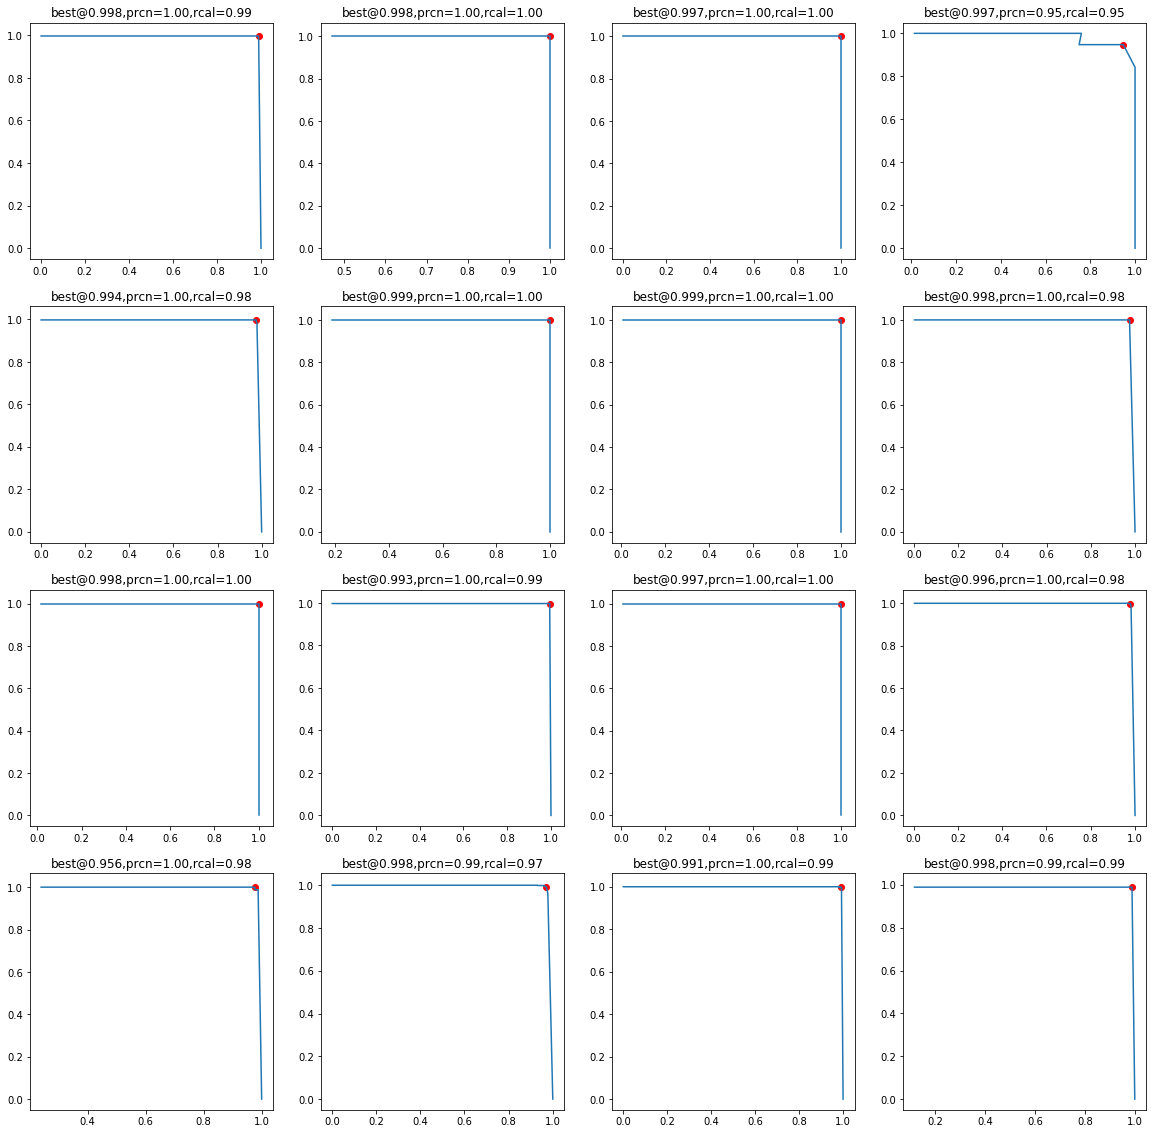

In [75]:
best_thress = draw_rpc(recall,precision,thress)

In [77]:
# 各类别的最优阈值的平均
best_thress.mean()

tensor(0.9942)

## ap and mAp

In [91]:
ap = get_AP(recall,precision)
ap

tensor([0.9063, 1.0000, 1.0000, 0.9761, 0.9072, 1.0000, 1.0000, 0.9091, 1.0000,
        0.9067, 1.0000, 0.9080, 0.9091, 0.9091, 0.9082, 0.8992])

In [92]:
mAp = ap.mean()
mAp

tensor(0.9462)

# export

In [ ]:
!python ../../notebook2script.py --fname 'evaluate.ipynb' --outputDir '../exp/'